# Artificial thymus organoid data preprocessing

#### Pipeline used to preprocess the raw thymus ATO data prior to G2G analysis
(Scripted by Dinithi following the initial (organoid) notebooks by Chenqu and reference related notebooks by Jong-Eun Park)

The preprocessing breakdown of 6 main steps is below.

1. Raw sample preprocessing and merge - includes initial filtering, scrublet doublet prediction
2. General preprocessing with doublet removal, gene filtering (non cell cycle,hgvs kept), normalisation/scaling, pca, and annotation (running celltypist and retreiving old annotations) 
3. Basic clustering and analysis -- most basic neighbourhood graph, leiden, umap without batch correction. 
4. SCVI batch corrected embedding on the full dataset, then leiden clustering and subsetting T, other immune and non immune cells based on leiden + old annotations manual inspection
5. SCVI batch corrected embedding on each of the step 4 subsets
6. Subsetting T lineage based on annotations (only on overall annotations) and SCVI batch corrected embedding on that
7. Loading New annotations by Chenqu

Subsetting is done to support the next stage refinement of annotations





In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import scvelo as scv 
import sys 
from scipy.sparse import csr_matrix
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import celltypist
from celltypist import models
import bbknn
import time
import scrublet
from scipy.spatial import distance
from scipy.sparse import csr_matrix
import anndata
import dorothea 
import time
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
ts=0
def TIME_LOG(*args):
    global ts
    if(args[0]==1): # start time log
        ts=time.time()
    elif(args[0]==2): # end time log and print time elapse   
        te=time.time()
        print(args[1]+' : ' + str(te-ts) + ' seconds')


### 1. Raw sample preprocessing and merge

In [2]:
# Run before souporcell 
RAW_DATA_PATH = 'ATO_data_samples_raw_21102021/'
sanger_sample_IDs = ['6180STDY8814872','6180STDY8814873','6180STDY9448806','6180STDY9448808','6180STDY9448811','6180STDY9448813','6180STDY10267835','6180STDY10267836']
capture_times = ['TO1 D-14','TO1 D-7','T03 GEX','T04 GEX', 'T05 GEX','T06 GEX','T09_Kolf_Fiaj__G','T10_Kolf_Fiaj__G']

def initial_raw_data_preprocessing(sanger_sample_id, write_barcode_file):

    print('Sanger sample id: ' , sanger_sample_id)
    path = RAW_DATA_PATH + 'raw_feature_bc_matrix_' + sanger_sample_id + '/'
    adata = sc.read(path+'matrix.mtx.gz',cache=True).transpose()
    adata.var_names = np.genfromtxt(path + 'features.tsv.gz',dtype=str)[:,1]
    adata.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz',dtype=str)
    adata.obs['sanger_sample_id'] = np.repeat(sanger_sample_id,adata.shape[0])
    # adata = sc.read_10x_h5(sample_raw_count_matrix_file) # this misses antibody hashtags specific features
    adata.var_names_make_unique()
    #print('Raw size: ',adata.shape)
    mito_genes = adata.var_names.str.startswith('GRCh38_MT-') # 13 mito genes presents
    human_genes = adata.var_names.str.startswith('GRCh38') # 33538 human genes present
    mouse_genes = adata.var_names.str.startswith('mm10_') # 31053 mouse genes present
    GEX = human_genes + mouse_genes
    #Antibody_capture = ~GEX
    #print('Antibody capture genes: ',np.unique(Antibody_capture,return_counts=True))
    #print(np.unique(np.sum(adata[:,Antibody_capture].X, axis=1).A1,return_counts=True))

    total_UMI_count_across_human_genes = np.sum(adata.X[:, human_genes],axis=1).A1 
    total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
    total_UMI_count_across_genes = np.sum(adata.X[:, GEX],axis=1).A1  # the total UMI count for each cell across all genes
    n_genes_expressed = np.sum(adata[:,GEX].X>0,axis=1).A1  # the # of genes that are expressed (UMI!=0)
    adata.obs['percent_total_human_UMI'] = np.nan_to_num(np.divide(total_UMI_count_across_human_genes,total_UMI_count_across_genes)) 
    adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
    adata.obs['human_cells'] = adata.obs['percent_total_human_UMI']>0.9
    adata.obs['total_UMI_count_across_genes'] = total_UMI_count_across_genes
    adata.obs['n_genes_expressed'] = n_genes_expressed 

    #print('Filtering cells')
    adata = adata[adata.obs['percent_total_human_UMI']>0.9]  #If >90% reads are from human genes then they are called human_cells
    adata = adata[adata.obs['total_UMI_count_across_genes'] > 2000]
    adata = adata[adata.obs['n_genes_expressed'] > 500] # sc.pp.filter_cells(adata_check, min_genes=500)
    adata = adata[adata.obs['n_genes_expressed'] < 7000] # sc.pp.filter_cells(adata_check, max_genes=7000)
    adata = adata[adata.obs['percent_total_mito_UMI']<0.2] # sc.pp.filter_cells(adata_check, min_counts=2000)
    
    # Write barcode list to csv file --- for running souporcell by Krzysztof
    #if(write_barcode_file):
    #    print('writing barcode file')
    #    pd.DataFrame(adata.obs_names).to_csv('Barcodes_'+sanger_sample_id+'.csv',index=False,header=False)
    #print('Filtered size: ',adata.shape)
    return adata

samples = [] 
for i in range(0,len(sanger_sample_IDs)):
    adata = initial_raw_data_preprocessing(sanger_sample_IDs[i], write_barcode_file=False)
    samples.append(adata)
    #print('---------------------------------------------------')
    
original_samples = samples.copy() 
souporcell_predictions = pd.read_csv('souporcell/ato/ATO_8SAMPLE/2/clusters.tsv',sep='\t')
souporcell_predictions.set_index(keys=['barcode'], inplace=True) 

for i in range(len(sanger_sample_IDs)):
    # record batch info (i.e. samples)
    samples[i].obs['sanger_sample_id'] = np.repeat(sanger_sample_IDs[i],samples[i].shape[0]) #(np.ones(samples[i].shape[0],dtype=np.int32) * i).astype(str)
    # doublet prediction record 
    barcodes = samples[i].obs_names
    df = souporcell_predictions.loc[(sanger_sample_IDs[i]+'-'+barcodes)]['status'] 
    samples[i].obs['souporcell_doublet_prediction'] = df.values
    df1 = souporcell_predictions.loc[(sanger_sample_IDs[i]+'-'+barcodes)]['log_prob_doublet']
    samples[i].obs['souporcell_doublet_logprob'] = df1.values
    samples[i].obs['batch'] = souporcell_predictions.loc[(sanger_sample_IDs[i]+'-'+barcodes)]['assignment'].values
    # [SCRUBLET] run scrublet --- batchwise??? 
    #scrub = scrublet.Scrublet(samples[i].X)
    #scrublet_doublet_scores, scrublet_predicted_doublets = scrub.scrub_doublets()
    #samples[i].obs['scrublet_doublet_scores'] = scrublet_doublet_scores
    #samples[i].obs['scrublet_predicted_doublets'] = scrublet_predicted_doublets

Sanger sample id:  6180STDY8814872
Sanger sample id:  6180STDY8814873
Sanger sample id:  6180STDY9448806
Sanger sample id:  6180STDY9448808
Sanger sample id:  6180STDY9448811
Sanger sample id:  6180STDY9448813
Sanger sample id:  6180STDY10267835
Sanger sample id:  6180STDY10267836


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [3]:
#original_samples = samples.copy() 
samples = original_samples.copy()
#for i in range(0,len(sanger_sample_IDs)):
    #print(np.unique(samples[i].obs['doublet_prediction'], return_counts=True))
    #samples[i] = samples[i][samples[i].obs['doublet_prediction']=='singlet']  # filtering doublets 
    
# common genes taken for the merge
sample_gene_lists =[]
for i in range(len(samples)):
    sample_gene_lists.append(samples[i].var_names) 
common_genes = set.intersection(*map(set,sample_gene_lists))
adata = samples[0][:,list(common_genes)].copy()
to_merge = []
for i in range(1,len(sanger_sample_IDs)):
    to_merge.append(samples[i][:,list(common_genes)])
adata = adata.concatenate(to_merge,batch_key=i, index_unique='-')

adata = adata[:,~adata.var_names.str.startswith('mm10')] # remove mouse genes
# making variable names (gene names) compatible with common gene names e.g. <hg38_1hho> = 1hho
modified_varnames = []
for gene in adata.var_names:
    modified_varnames.append(gene[7:len(gene)])
adata.var_names = modified_varnames

adata.obs = adata.obs.rename(columns={7:'sample'}) # unnecessary col which I did not intend to have
adata.obs['time_id'] = np.repeat(sanger_sample_IDs[0],adata.shape[0])
for i in range(0,len(sanger_sample_IDs)):
    temp = adata[adata.obs['sanger_sample_id']== sanger_sample_IDs[i]]
    adata.obs['time_id'][adata.obs['sanger_sample_id']== sanger_sample_IDs[i]] = (np.repeat(capture_times[i],temp.shape[0]))
#adata.write_h5ad('ATO_data/ATO_merged_b4_preprocessing.h5ad')

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 26.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 86.4 seconds


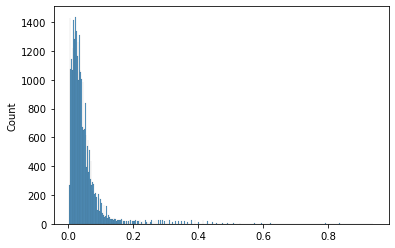

In [5]:
scrub = scrublet.Scrublet(adata.X)
scrublet_doublet_scores, scrublet_predicted_doublets = scrub.scrub_doublets()
sb.histplot(scrublet_doublet_scores)
adata.obs['scrublet_doublet_scores'] = scrublet_doublet_scores
adata.obs['scrublet_predicted_doublets'] = scrublet_predicted_doublets

In [6]:
adata.write_h5ad('DataObjects/ATO_merged_b4_preprocessing_1.h5ad')

... storing 'sanger_sample_id' as categorical
... storing 'souporcell_doublet_prediction' as categorical
... storing 'batch' as categorical
... storing 'time_id' as categorical


### 2. Preprocessing 

In [2]:
adata = anndata.read_h5ad('DataObjects/ATO_merged_b4_preprocessing_1.h5ad')
# filtering doublets
CUTOFF = 0.15
adata = adata[adata.obs['souporcell_doublet_prediction'] =='singlet'] 
adata = adata[adata.obs['scrublet_doublet_scores']<CUTOFF]

In [5]:
# remove cell cycle genes
cc_genes = ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
relevent_cc_genes = [] 
for cc_gene in cc_genes:
    if(cc_gene in adata.var_names):
        relevent_cc_genes.append(cc_gene)
adata = adata[:,np.setdiff1d(adata.var_names,relevent_cc_genes)] 

In [7]:
sc.pp.filter_genes(adata, min_cells=3) 
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars= ['mt'],percent_top=None, log1p=False, inplace=True)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata,svd_solver='arpack',use_highly_variable=True)

Trying to set attribute `.var` of view, copying.


In [9]:
run_celltypist = True
if(run_celltypist):
    predictions = celltypist.annotate(adata, model = 'Celltypist/pan_fetal/models/Pan_Fetal_Human.pkl',majority_voting=True)
    predictions_high_level = celltypist.annotate(adata, model = "Immune_Thymus_High.pkl", majority_voting=True)
    predictions_low_level = celltypist.annotate(adata, model = "Immune_Thymus_Low.pkl", majority_voting=True)
    adata.obs['celltypist_panfetal_predictions'] = predictions.predicted_labels['majority_voting']
    adata.obs['celltypist_high_level_predictions'] = predictions_high_level.predicted_labels['majority_voting']
    adata.obs['celltypist_low_level_predictions'] = predictions_low_level.predicted_labels['majority_voting']
    
    high_level_predictions = []
    for i in range(0,adata.shape[0]):
        annotation = adata.obs['celltypist_panfetal_predictions'][i]
        if(annotation.startswith('DP')):
            high_level_predictions.append('DP')
        elif(annotation.startswith('DN')):
            high_level_predictions.append('DN')      
        elif(annotation.startswith('MONOCYTE')):
            high_level_predictions.append('MONOCYTE')   
        elif(annotation.endswith('INNATE_T')):
            high_level_predictions.append('INNATE_T') 
        elif(annotation.endswith('_MK')):
            high_level_predictions.append('MK') 
        elif(annotation.endswith('_MPP')):
            high_level_predictions.append('MPP') 
        elif(annotation.endswith('_MEMP')):
            high_level_predictions.append('MEMP') 
        elif(annotation.endswith('_NK')):
            high_level_predictions.append('NK') 
        else:
            high_level_predictions.append(annotation)
    adata.obs['celltypist_panfetal_predictions_high_level'] = high_level_predictions

👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 31483 cells and 23526 genes
🔗 Matching reference genes in the model
🧬 6435 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 31483 cells and 23526 genes
🔗 Matching reference genes in the model
🧬 3681 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
👀 Detected scaled expression in the input data, will try the .raw attribute

In [12]:
# retreiving past ATO annotations only for the available cells
def get_existing_ato():
    adata = sc.read_h5ad("jovyan_25082021/thymic_organoid_new/write/ATO.A05.v01.merged_annotated.h5ad")
    # NOTE: Chenqu's normalised data is with target_sum = 100,000 
    adata.var_names_make_unique()
    # making variable names (gene names) compatible with common gene names e.g. <hg38_1hho> = 1hho
    modified_varnames = []
    for gene in adata.var_names:
        modified_varnames.append(gene[7:len(gene)])
    adata.var_names = modified_varnames
    return adata
adata_old_ato = get_existing_ato()

In [14]:
adata.obs['old_anno_lvl_0'] = np.repeat('nan',adata.shape[0])
adata.obs['old_anno_lvl_1'] = np.repeat('nan',adata.shape[0])
adata.obs['old_anno_lvl_2'] = np.repeat('nan',adata.shape[0])
#adata_backup = adata.copy()

In [22]:
for i in range(0,adata.shape[0]):
    cell_id = (adata.obs['sanger_sample_id'][i]+'-'+adata.obs_names[i].split('-')[0])
    temp = np.where(adata_old_ato.obs_names.str.startswith(cell_id))[0] 
    #print(cell_id,temp)
    if(len(temp)==1):
        old_id = adata_old_ato.obs_names[np.where(adata_old_ato.obs_names.str.startswith(cell_id))[0][0]]
        adata.obs['old_anno_lvl_0'][i] = adata_old_ato.obs['anno_lvl_0'][old_id]
        adata.obs['old_anno_lvl_1'][i] = adata_old_ato.obs['anno_lvl_1'][old_id]
        adata.obs['old_anno_lvl_2'][i] = adata_old_ato.obs['anno_lvl_2'][old_id]
#for i in range(0,adata.shape[0]):
#    if(adata.obs['old_anno_lvl_1'][i] == 'None'):
#        adata.obs['old_anno_lvl_1'][i] = np.NaN

In [24]:
adata.write_h5ad('DataObjects/ATO_preprocessed_annotated_2.h5ad')

... storing 'celltypist_panfetal_predictions_high_level' as categorical
... storing 'old_anno_lvl_0' as categorical
... storing 'old_anno_lvl_1' as categorical
... storing 'old_anno_lvl_2' as categorical


### 3. Basic clustering and analysis

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata) 
sc.pl.umap(adata,color=['old_anno_lvl_0','celltypist_panfetal_predictions_high_level'])

In [70]:
# just replacing nans properly 
nan_indices = np.where(adata.obs['old_anno_lvl_0']=='nan')
for i in nan_indices:
    adata.obs['old_anno_lvl_0'][i] = np.NaN
# Just for consistency between different annotation sources
def overall_annotations_correct(adata):
    adata.obs['overall_annotation'] = np.repeat('',adata.shape[0])
    for i in range(0,adata.shape[0]):
        if(pd.isna(adata.obs['old_anno_lvl_0'][i]) and (not pd.isna(adata.obs['celltypist_panfetal_predictions_high_level'][i]))):
            adata.obs['overall_annotation'][i] = adata.obs['celltypist_panfetal_predictions_high_level'][i] 
        else:
            if(adata.obs['celltypist_panfetal_predictions_high_level'][i] in ['CYCLING_EPITHELIUM','VSMC_PERICYTE_III','LOW_QUALITY']):
                adata.obs['overall_annotation'][i] = adata.obs['old_anno_lvl_0'][i]
            else:
                adata.obs['overall_annotation'][i] = adata.obs['celltypist_panfetal_predictions_high_level'][i] 
        if(adata.obs['overall_annotation'][i] in ['INNATE_T','Innate_T']):
            adata.obs['overall_annotation'][i] = 'INNATE_T'
        if(pd.isna(adata.obs['overall_annotation'][i])):
            print(adata.obs['overall_annotation'][i],adata.obs['celltypist_panfetal_predictions_high_level'][i],adata.obs['old_anno_lvl_0'][i] )
            break
    return adata              
adata= overall_annotations_correct(adata)

In [ ]:
sc.pl.umap(adata,color=['overall_annotation'])

In [ ]:
def subset_T(adata):
    T_lineage_cells = []
    for i in range(0, adata.shape[0]):
        if(adata.obs['overall_annotation'][i] in ['iPSC','hEMP','SP','Innate_lymphoid','Innate_T','INNATE_T','ILC3','DN','DP','ETP']):
            T_lineage_cells.append(adata.obs_names[i])
    adata_T = adata[T_lineage_cells]
    return adata_T

adata_T = subset_T(adata)
sc.pl.umap(adata_T,color=['overall_annotation'])

### 4. SCVI Run and Leiden clustering for the full dataset

In [ ]:
import scanpy as sc
import scvi 
import anndata
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pandas as pd
import seaborn as sb

torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

adata = anndata.read_h5ad('ATO_preprocessed_annotated_2.h5ad')

# just replacing nans properly 
nan_indices = np.where(adata.obs['old_anno_lvl_0']=='nan')
for i in nan_indices:
    adata.obs['old_anno_lvl_0'][i] = np.NaN
def overall_annotations_correct(adata):
    adata.obs['overall_annotation'] = np.repeat('',adata.shape[0])
    for i in range(0,adata.shape[0]):
        if(pd.isna(adata.obs['old_anno_lvl_0'][i]) and (not pd.isna(adata.obs['celltypist_panfetal_predictions_high_level'][i]))):
            adata.obs['overall_annotation'][i] = adata.obs['celltypist_panfetal_predictions_high_level'][i] 
        else:
            if(adata.obs['celltypist_panfetal_predictions_high_level'][i] in ['CYCLING_EPITHELIUM','VSMC_PERICYTE_III','LOW_QUALITY']):
                adata.obs['overall_annotation'][i] = adata.obs['old_anno_lvl_0'][i]
            else:
                adata.obs['overall_annotation'][i] = adata.obs['celltypist_panfetal_predictions_high_level'][i] 
        if(adata.obs['overall_annotation'][i] in ['INNATE_T','Innate_T']):
            adata.obs['overall_annotation'][i] = 'INNATE_T'
        if(pd.isna(adata.obs['overall_annotation'][i])):
            print(adata.obs['overall_annotation'][i],adata.obs['celltypist_panfetal_predictions_high_level'][i],adata.obs['old_anno_lvl_0'][i] )
            break
    return adata              
adata= overall_annotations_correct(adata)

# Capture time recording 
adata.obs['ATO_days'] = np.repeat(0,adata.shape[0])
time_m = {'TO1 D-7':-7.0, 'TO1 D-14':-14.0,'T03 GEX':7,'T04 GEX':20.0, 'T05 GEX':37.0, 'T06 GEX':50,'T09_Kolf_Fiaj__G':-7.0,'T10_Kolf_Fiaj__G':0 }
for i in range(0,adata.shape[0]):
    if(not pd.isna(adata.obs['time_id'][i])):
        adata.obs['ATO_days'][i] = time_m[adata.obs['time_id'][i]]

In [ ]:
def run_scvi(adata):
    scvi.model.SCVI.setup_anndata(adata, batch_key="batch", layer="counts")
    arches_params = dict(use_layer_norm="both",use_batch_norm="none", encode_covariates=True, dropout_rate=0.2, n_layers=2,)
    vae_ref = scvi.model.SCVI(adata,**arches_params)
    vae_ref.train()
    adata.obsm["X_scVI"] = vae_ref.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added='SCVI_leiden')
    return adata
    
adata = run_scvi(adata) 

In [ ]:
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata,color = ['overall_annotation'],palette='tab20',legend_loc='on data')
sc.pl.umap(adata,color = ['SCVI_leiden'], palette='tab20',legend_loc='on data')

In [ ]:
# Subsetting T lineage, non immune cells, other immune cells from Leiden clustering based on previous annotations -- after manual inspection 
T_lineage_cells = [] # DN, DP, ILC3, INNATE_T, NK, abT(entry), CD8AA,
non_immune_cells = [] # iPSC, hEMP, LOW_QUALITY, DEVELOPING_NEPHRON_I,GLIAL, VSMC_PERICYTE_III, CYCLING_EPITHELIUM, KERATINOCYTE, ENDOTHELIUM_I,SMOOTH_MUSCLE
other_immune_cells = [] 
for i in range(0, adata.shape[0]):
    if(adata.obs['SCVI_leiden'][i] in ['9','0','3','23','16','12','4','27']):
        T_lineage_cells.append(adata.obs_names[i])
    elif(adata.obs['SCVI_leiden'][i] in ['1','17','22','21','8','5']):
        non_immune_cells.append(adata.obs_names[i])
    else:
        other_immune_cells.append(adata.obs_names[i])

In [ ]:
#pd.DataFrame(np.transpose(np.unique(adata[non_immune_cells].obs['overall_annotation'], return_counts=True) ) ) 
#pd.DataFrame(np.transpose(np.unique(adata[T_lineage_cells].obs['overall_annotation'], return_counts=True))) 
#pd.DataFrame(np.transpose(np.unique(adata[other_immune_cells].obs['overall_annotation'], return_counts=True))) 
adata[T_lineage_cells].write_h5ad('DataObjects/ATO_subset_T_4.h5ad')
adata[non_immune_cells].write_h5ad('DataObjects/ATO_subset_non_immune_4.h5ad')
adata[other_immune_cells].write_h5ad('DataObjects/ATO_subset_other_immune_4.h5ad')
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata[T_lineage_cells],color = ['overall_annotation','SCVI_leiden'],palette='tab20',legend_loc='on data')
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata[non_immune_cells],color = ['overall_annotation','SCVI_leiden'],palette='tab20',legend_loc='on data')
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata[other_immune_cells],color = ['overall_annotation','SCVI_leiden'],palette='tab20',legend_loc='on data')

In [ ]:
adata.write_h5ad('DataObjects/ATO_full_scvi_4.h5ad')

### 5. Separate scvi run for each subset from Leiden clustering above

In [ ]:
adata_T = adata[T_lineage_cells].copy()
adata_other_immune = adata[other_immune_cells].copy()
adata_non_immune = adata[non_immune_cells].copy()

def process_subset(adata):
    adata = run_scvi(adata) 
    sc.tl.leiden(adata)
    return adata

adata_T = process_subset(adata_T)
adata_other_immune = process_subset(adata_other_immune)
adata_non_immune = process_subset(adata_non_immune)

sc.set_figure_params(fontsize=4, dpi=150)
sc.pl.umap(adata_T,color = ['overall_annotation','leiden'],palette='tab20',legend_loc='on data')
sc.set_figure_params(fontsize=4, dpi=150)
sc.pl.umap(adata_non_immune,color = ['overall_annotation','leiden'],palette='tab20',legend_loc='on data')
sc.set_figure_params(fontsize=4, dpi=150)
sc.pl.umap(adata_other_immune,color = ['overall_annotation','leiden'],palette='tab20',legend_loc='on data')

adata_T.write_h5ad('DataObjects/ATO_subset_T_5.h5ad')
adata_other_immune.write_h5ad('DataObjects/ATO_subset_other_immune_5.h5ad')
adata_non_immune.write_h5ad('DataObjects/ATO_subset_non_immune_5.h5ad')

### 7. Annotated data loading and saving
(Annoted by Chenqu)

In [3]:
def read_and_store_annotations(adata_file, annotation_csv_file, do_plot=True):
    full_annotations = pd.read_csv(annotation_csv_file)
    adata = anndata.read_h5ad(adata_file)

    unique_ids = [] 
    sanger_ids = list(full_annotations['sanger_sample_id'])
    full_annotations = full_annotations.set_index('sanger_sample_id')
    for i in range(adata.shape[0]):
        barcode = adata.obs_names[i]
        unique_id = adata.obs['sanger_sample_id'][i] + '-' + barcode[0:len(barcode)-4]
        if(unique_id in sanger_ids):
            unique_ids.append(unique_id)
    adata.obs['unique_id'] = unique_ids

    new_annotations = []
    for i in range(adata.shape[0]):
        new_annotations.append(full_annotations.loc[unique_ids[i]]['anno_lvl_2'])
    adata.obs['new_annotation'] = new_annotations
    if(do_plot):
        sc.pl.umap(adata,color='new_annotation', legend_loc='on data')
    return adata 

In [95]:
# ===========================================================================================================================================
# RUN ONCE ONLY FOR FULL ANNOTATION DATA --- [recording step]
# Adding EPCAM and MKI67 genes expression back to full adata for downstream analysis - they got removed due to being in the cc genes list.
# Note: for consistency, let us store all genes log1p, normalised expression in adata.raw  (no gene filtering)
adata_raw = anndata.read_h5ad('DataObjects/ATO_merged_b4_preprocessing_1.h5ad')
# filtering doublets
CUTOFF = 0.15
adata_raw = adata_raw[adata_raw.obs['souporcell_doublet_prediction'] =='singlet'] 
adata_raw = adata_raw[adata_raw.obs['scrublet_doublet_scores']<CUTOFF]
adata_raw.var['mt'] = adata_raw.var_names.str.startswith('MT-') 
sc.pp.normalize_per_cell(adata_raw, 10000) 
sc.pp.log1p(adata_raw)
adata.raw = adata_raw
adata.write_h5ad('DataObjects/ATO_full_scvi_4_with_new_annotations_7.h5ad')
# ===========================================================================================================================================

Trying to set attribute `.var` of view, copying.


... storing 'new_annotation' as categorical


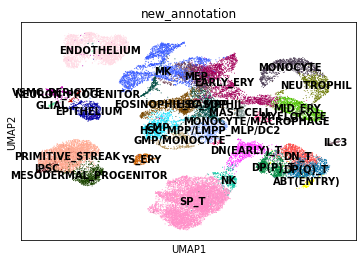

... storing 'new_annotation' as categorical


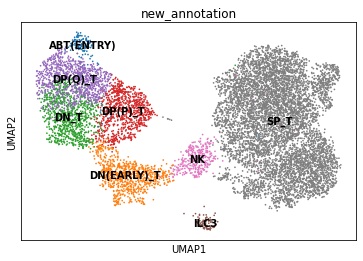

... storing 'new_annotation' as categorical


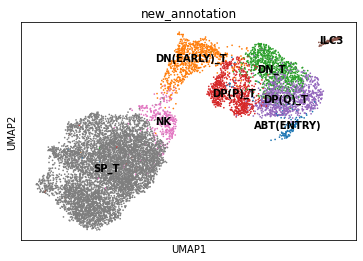

... storing 'new_annotation' as categorical


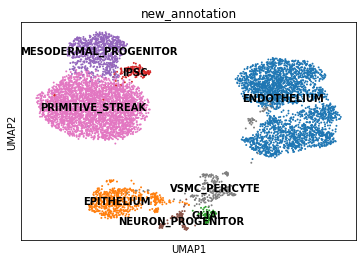

In [135]:
adata = read_and_store_annotations('DataObjects/ATO_full_scvi_4.h5ad','ATO_full_scvi_4_anno.csv' )
adata = read_and_store_annotations('DataObjects/ATO_subset_T_5.h5ad','ATO_full_scvi_4_anno.csv' )
# NOTE: single positive T cells are usually considered mature T cells. Here SP_T are unconventional T cells (NKT,TH17,CD8AA) -- PLZF expressing 
adata =read_and_store_annotations('DataObjects/ATO_subset_T_4.h5ad','ATO_full_scvi_4_anno.csv' )
adata = read_and_store_annotations('DataObjects/ATO_subset_non_immune_5.h5ad','ATO_full_scvi_4_anno.csv' )
#adata = read_and_store_annotations('DataObjects/ATO_subset_other_immune_5.h5ad','ATO_merge_Dinithi/csv/ATO_full_scvi_4_anno.csv' )

In [137]:
adata = read_and_store_annotations('DataObjects/ATO_full_scvi_4.h5ad','ATO_full_scvi_4_anno.csv', do_plot=False)

In [140]:
# subsetting T lineage with early cells as well
T_lineage_cell_types = ['ABT(ENTRY)','DN(EARLY)_T','DN_T', 'DP(P)_T', 'DP(Q)_T', 'ENDOTHELIUM','HSC_MPP','HSC_MPP/LMPP_MLP/DC2','ILC3','IPSC','MESODERMAL_PROGENITOR','NK','PRIMITIVE_STREAK','SP_T']
T_lineage_subset = [] 
for i in range(adata.shape[0]):
    if(adata.obs['new_annotation'][i] in T_lineage_cell_types):
        T_lineage_subset.append(adata.obs_names[i])
adata_T = adata[T_lineage_subset]

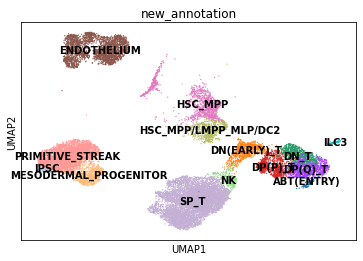

In [156]:
sc.pl.umap(adata_T,color='new_annotation', legend_loc='on data')

In [163]:
adata_T.write_h5ad('DataObjects/My_subset_adata_7/ATO_subset_T_lineage_full.h5ad')